## 1. 예측 모델에 대한 개발 설명 

### A. 분석 배경 및 과정
저희는 보유기간을 예측하기 위해 크게 3가지 방향성으로 접근하였습니다.
1. 고객의 성향에 따른 보유기간
- 고객별 단타 횟수, 장타 횟수, 구매 종목 개수, 나이에 수익률, 성별에 따른 수익률 등 결과적으로 고객의 특성에 따른 변수들이 거의 채택 되었습니다.
2. 종목에 따른 보유기간
- 종목별 평균 보유기간, 종목별 단타 및 장타 횟수, 대형주 및 소형주, 배당금의 유무 등은 성능 향상이 되지 않았습니다
3. 산 시점의 외부 요인
- 산 시점의 거래량, 등락률, 폭락장 및 폭등장, 개인의 매수금액, 거래 대금 등 시계열데이터로 적용 하였을 때 모델의 성능 향상은 볼 수 없었습니다. 구매 시점의 큰 외부 요인은 발견하지 못하였습니다.




In [1]:
import os
path = 'C:\\Users\\USER\\Desktop\\새 폴더 (3)\\open\\'

import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor


cus = pd.read_csv(path + "/cus_info.csv")
iem = pd.read_csv(path + "/iem_info.csv")
hist = pd.read_csv(path + "/stk_bnc_hist.csv")
train = pd.read_csv(path + "/stk_hld_train.csv")
test = pd.read_csv(path + "/stk_hld_test.csv")
submission = pd.read_csv(path + "/sample_submission.csv")

### A'. 채택된 변수에 대한 설명

# 장타율 단타율

 - 먼저, 단타를 주로 하는 사람들, 장타를 주로 하는사람들을 표현하기 위해 사람들의 평균 보유기간(Past_d)과 종목별 평균 보유기간(iem_hist)를 만들어서 적용해 보았지만, 성능이 향상되지 않았습니다. 
 
 - 이유는 보유기간을 수치 자체로 예측을 하게 되면 이상치의 영향을 매우 크게 받기 때문이라고 생각했습니다. 따라서 구간을 나누어서 68만개 Train set에 대하여 hold의 기준에 따른 횟수를 구하여 고객의 특성으로 병합하였습니다.
 
 - 또한 Recent_flow는 최근 고객의 횟수 특성으로, Test data의 Hist에 대해 hist의 횟수를 정하였고, Test set의 특성상 한달 미만의 hist_d가 적어 1개월 이상, 6개월 이상의 횟수만 적용하였습니다.
 
 - 아래가 장타율,단타율을 반영한 지표 5개입니다.


# Short_hit
- hold_d가 5일 미만인 횟수를 구했습니다.

# Middle_hit
- hold_d가 5일~24일인 횟수를 구했습니다.

# Long_hit
- hold_d가 24일 이상인 횟수를 구했습니다. 

# Recent_flow
- hist_d가 24 이상인 횟수를 구했습니다

# Recent_longflow
- hist_d가 140이상인 횟수를 구했습니다.

In [2]:
# recent_flow 계산

# 1달 이상 Recent_flow
test_24upper = test[test['hist_d'] >= 24]
recent_flow = test_24upper['hist_d'].groupby(test_24upper['act_id']).count()

# 6달이상 Recent_longflow
test_140upper = test[test['hist_d'] > 140]
test_140upper.reset_index(drop = True, inplace = True)
recent_longflow = test_140upper['hist_d'].groupby(test_140upper['act_id']).count()

cus = pd.merge(cus, recent_flow, how='left', on='act_id')
cus['recent_flow'] = cus['hist_d']
cus = cus.drop(['hist_d'],axis = 1)

cus = pd.merge(cus, recent_longflow, how='left', on='act_id')
cus['recent_longflow'] = cus['hist_d']
cus = cus.drop(['hist_d'],axis = 1).fillna(0)

cus

,act_id,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,recent_flow,recent_longflow
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16,2.0,2.0
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1,12.0,6.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9,6.0,2.0
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16,13.0,13.0
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2fdd734bf8fc04c0d484ddc1d021622a1cdc802705702e...,1,9,4,2,2,9,5,2,16,1.0,1.0
9996,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2,2,3,1,2,2,9,1,16,5.0,0.0
9997,7702030b3b0760e6b37c8a3e8ed58611b1b85913526ad1...,2,7,4,2,2,5,5,2,16,5.0,0.0
9998,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,1,5,99,5,2,5,3,2,5,3.0,0.0


In [3]:
# Short, Middle, Long hit 계산

# 1주미만 횟수 
train_5lower = train[train['hold_d'] <= 5]
train_5lower.reset_index(drop = True, inplace = True)
short_hit = train_5lower['hold_d'].groupby(train_5lower['act_id']).count()

# 1달미만 횟수 
train_6upper = train[train['hold_d'] >= 6]
train_23lower = train_6upper[train_6upper['hold_d'] <= 23]
train_23lower.reset_index(drop = True, inplace = True)
middle_hit = train_23lower['hold_d'].groupby(train_23lower['act_id']).count()

# 1달 ~ 이후
train_24upper = train[train['hold_d'] >= 24]
long_hit = train_24upper['hold_d'].groupby(train_24upper['act_id']).count()

cus = pd.merge(cus, short_hit, how='left', on='act_id')
cus['short_hit'] = cus['hold_d']
cus = cus.drop(['hold_d'],axis = 1 )      

cus = pd.merge(cus, middle_hit, how='left', on='act_id')
cus['middle_hit'] = cus['hold_d']
cus = cus.drop(['hold_d'],axis = 1)

cus = pd.merge(cus, long_hit, how='left', on='act_id')
cus['long_hit'] = cus['hold_d']
cus = cus.drop(['hold_d'],axis = 1)

cus = cus.fillna(0)
cus

,act_id,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,recent_flow,recent_longflow,short_hit,middle_hit,long_hit
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16,2.0,2.0,0.0,0.0,1.0
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1,12.0,6.0,19.0,17.0,27.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9,6.0,2.0,0.0,1.0,5.0
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16,13.0,13.0,2.0,7.0,11.0
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16,3.0,3.0,5.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2fdd734bf8fc04c0d484ddc1d021622a1cdc802705702e...,1,9,4,2,2,9,5,2,16,1.0,1.0,0.0,0.0,2.0
9996,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2,2,3,1,2,2,9,1,16,5.0,0.0,8.0,5.0,1.0
9997,7702030b3b0760e6b37c8a3e8ed58611b1b85913526ad1...,2,7,4,2,2,5,5,2,16,5.0,0.0,0.0,0.0,0.0
9998,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,1,5,99,5,2,5,3,2,5,3.0,0.0,3.0,1.0,2.0


# age_profit
 - 외부데이터의 링크를 참고하면, 나이에 따라 회전율(거래횟수)이 많으면 많을 수록 수익이 낮고, 나이가 어려진다는 것을 알 수 있습니다. 회전율이 많으면 주식을 사기만 하지 않는이상 보유기간도 함께 낮아질 것이기 때문에, 나이에 따른 수익률을 새로운 feature로 두었습니다.

In [4]:
# age_profit 대입 
# 기사에서 나이별 수익률을 10.45%, 15.87%, 22.28%, 22.42%, 23.57%를 참고하여 feature를 반영
cus['age_profit'] = cus['cus_age_stn_cd'].replace(1,10.45).replace(2,10.45).replace(3,18.87).replace(4,18.87).replace(5,22.28).replace(6,22.28).replace(7,22.42).replace(8,22.42).replace(9,23.57)
cus.drop(['cus_age_stn_cd'], axis = 1, inplace = True)
cus

,act_id,sex_dit_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,recent_flow,recent_longflow,short_hit,middle_hit,long_hit,age_profit
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,99,1,2,3,3,6,16,2.0,2.0,0.0,0.0,1.0,18.87
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,4,4,2,5,2,6,1,12.0,6.0,19.0,17.0,27.0,22.28
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,4,3,2,5,5,6,9,6.0,2.0,0.0,1.0,5.0,22.42
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,4,4,8,5,3,6,16,13.0,13.0,2.0,7.0,11.0,22.28
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,2,2,2,5,5,5,16,3.0,3.0,5.0,4.0,6.0,22.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2fdd734bf8fc04c0d484ddc1d021622a1cdc802705702e...,1,4,2,2,9,5,2,16,1.0,1.0,0.0,0.0,2.0,23.57
9996,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2,3,1,2,2,9,1,16,5.0,0.0,8.0,5.0,1.0,10.45
9997,7702030b3b0760e6b37c8a3e8ed58611b1b85913526ad1...,2,4,2,2,5,5,2,16,5.0,0.0,0.0,0.0,0.0,22.42
9998,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,1,99,5,2,5,3,2,5,3.0,0.0,3.0,1.0,2.0,22.28


# iem_variety
  - 총 거래 기간동안, 각 고객이 몇 가지의 종목을 샀는지를 나타내는 feature입니다. 많은 종목을 산 고객일 수록 단타경향성이 보여 feature로 두었습니다.
  

In [5]:
# iem_variety 계산

hist_dup = hist.drop_duplicates(['act_id', 'iem_cd'], keep='first')
hist_dup.reset_index(drop = True, inplace = True)

hist_group = hist_dup.groupby(hist_dup['act_id']).count().reset_index()

hist_group['iem_variety'] = hist_group['bse_dt']

variety = hist_group[['act_id', 'iem_variety']]

cus = pd.merge(cus, variety, how='left', on = 'act_id')

cus

,act_id,sex_dit_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,recent_flow,recent_longflow,short_hit,middle_hit,long_hit,age_profit,iem_variety
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,99,1,2,3,3,6,16,2.0,2.0,0.0,0.0,1.0,18.87,3.0
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,4,4,2,5,2,6,1,12.0,6.0,19.0,17.0,27.0,22.28,69.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,4,3,2,5,5,6,9,6.0,2.0,0.0,1.0,5.0,22.42,13.0
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,4,4,8,5,3,6,16,13.0,13.0,2.0,7.0,11.0,22.28,31.0
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,2,2,2,5,5,5,16,3.0,3.0,5.0,4.0,6.0,22.28,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2fdd734bf8fc04c0d484ddc1d021622a1cdc802705702e...,1,4,2,2,9,5,2,16,1.0,1.0,0.0,0.0,2.0,23.57,3.0
9996,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2,3,1,2,2,9,1,16,5.0,0.0,8.0,5.0,1.0,10.45,14.0
9997,7702030b3b0760e6b37c8a3e8ed58611b1b85913526ad1...,2,4,2,2,5,5,2,16,5.0,0.0,0.0,0.0,0.0,22.42,5.0
9998,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,1,99,5,2,5,3,2,5,3.0,0.0,3.0,1.0,2.0,22.28,5.0


# sex_profit
 - 외부데이터의 링크를 참고하면, 성별에 따라 수익률이 차이가 나는 것을 알 수 있습니다. 따라서 위의 age_profit에서의 insight를 참고하여, 성별에 따른 수익률을 새로운 feature로 두었습니다.



In [6]:
# sex_profit 계산

# 남성 수익률 18.3% , 24.2% 수익률이 높을수록, 보유기간이 클 확률이 큼 
cus['sex_profit'] = cus['sex_dit_cd'].replace(1,0.183).replace(2,0.242)
cus.drop(['sex_dit_cd'], axis = 1, inplace = True)
cus

,act_id,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,recent_flow,recent_longflow,short_hit,middle_hit,long_hit,age_profit,iem_variety,sex_profit
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,99,1,2,3,3,6,16,2.0,2.0,0.0,0.0,1.0,18.87,3.0,0.183
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,4,4,2,5,2,6,1,12.0,6.0,19.0,17.0,27.0,22.28,69.0,0.183
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,4,3,2,5,5,6,9,6.0,2.0,0.0,1.0,5.0,22.42,13.0,0.242
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,4,4,8,5,3,6,16,13.0,13.0,2.0,7.0,11.0,22.28,31.0,0.242
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,2,2,2,5,5,5,16,3.0,3.0,5.0,4.0,6.0,22.28,15.0,0.183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2fdd734bf8fc04c0d484ddc1d021622a1cdc802705702e...,4,2,2,9,5,2,16,1.0,1.0,0.0,0.0,2.0,23.57,3.0,0.183
9996,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,3,1,2,2,9,1,16,5.0,0.0,8.0,5.0,1.0,10.45,14.0,0.242
9997,7702030b3b0760e6b37c8a3e8ed58611b1b85913526ad1...,4,2,2,5,5,2,16,5.0,0.0,0.0,0.0,0.0,22.42,5.0,0.242
9998,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,99,5,2,5,3,2,5,3.0,0.0,3.0,1.0,2.0,22.28,5.0,0.183


채택된 변수는 총 10개입니다. 

# hist_d
 - hist_d를 특정 비율로 환산하여 학습을 진행했을때 항상 오버피팅이 되었습니다. 때문에 특정 비율이 아닌 특정 지점으로 차이를 구한다는 생각을 했고 2020년 1월 1일 기준으로, 2020년 전에 주식을 보유하여, 2020년에 팔았던 회원들을 뽑아 각각 hist_d를 계산하여 사용했습니다.
 - 날짜로 환산할 때 공휴일,주말을 고려하여 계산하여 hold->날짜시엔 1.517가중치를 주었고 날짜->hold로 환산할때에는 0.659의 가중치를 주었습니다.

In [7]:
# hist를 2020년 01월 01일 기준으로 산출

df = pd.DataFrame()
train['hold_d'] = train['hold_d'] * 1.517 # hold_d는 실 영업일이기 때문에 주말+공휴일을 감안한 1.517 곱해줌

from datetime import datetime
from datetime import timedelta

train['byn_dt'] = train['byn_dt'].astype('str')
train['byn_dt'] = pd.to_datetime(train['byn_dt']) 

import datetime
day1 = datetime.date(2020, 1, 1) # 2020. 01. 01을 기준

# 2020. 01. 01 전에 구매하고, 2020년에 매도한 데이터를 df에 저장
for i in range(len(train)):
    a = train['hold_d'][i]
    a = int(a)
    if train['byn_dt'][i] < day1 and train['byn_dt'][i] + datetime.timedelta(days = a) > day1:
        df = df.append(train.loc[i])
df.reset_index(drop = True, inplace = True)


from datetime import datetime

now  = df['byn_dt']
#print("현재 :", now)   # byn_dt를 now

date_to_compare = datetime.strptime("20200101", "%Y%m%d") 
#print("비교할 날짜 :", date_to_compare)   # 비교할 날짜  

date_diff = (date_to_compare - now)
#print("차이 :", date_diff) # 차이 date_diff

df['sigan'] =  date_diff # 


df['sigan'] = df['sigan'].dt.days
df['hold_d'] = df['hold_d'].astype(int) # 시간의 타입을 int형으로 바꾸면 hist가 됨 

df['hist_d'] = df['sigan']
df['hold_d'] = df['hold_d']*0.659
df['hist_d'] = df['hist_d']*0.659

df['hold_d'] = df['hold_d'].astype(int)
df['hist_d'] = df['hist_d'].astype(int)

df = df.drop(['sigan'], axis=1)

train_data = df
train_data

,act_id,byn_dt,hold_d,iem_cd,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,2018-09-05,323,A002310,318
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,2019-01-29,224,A086520,222
2,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,2018-06-08,477,A100130,376
3,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,2019-04-24,173,A128820,166
4,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,2019-09-24,70,A043200,65
...,...,...,...,...,...
18491,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,2019-10-30,71,A067630,41
18492,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,2019-10-28,122,A028300,42
18493,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,2019-11-20,37,A100700,27
18494,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,2019-07-01,261,A026960,121


- 차이값이 250일이 넘는 50개는 outlier로 판단하고 제거해주었습니다

In [8]:
# 250일이 넘는 outlier 제거
train_data = train_data[train_data['hold_d'] - train_data['hist_d'] <= 250]
train_data

,act_id,byn_dt,hold_d,iem_cd,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,2018-09-05,323,A002310,318
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,2019-01-29,224,A086520,222
2,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,2018-06-08,477,A100130,376
3,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,2019-04-24,173,A128820,166
4,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,2019-09-24,70,A043200,65
...,...,...,...,...,...
18491,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,2019-10-30,71,A067630,41
18492,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,2019-10-28,122,A028300,42
18493,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,2019-11-20,37,A100700,27
18494,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,2019-07-01,261,A026960,121


# rotation_rate

- 앞서 자금 회전율이 보유기간, 수익률과 반비례한다는 insight를 얻었습니다. 그에 따라 고객별 회전율을 새로운 feature로 두었습니다. 산출 방식은 다음과 같습니다.
- 고객별 총 거래 횟수 / 투자기간(TOT_IVS_TE_SGM_CD) = 회전율(rotation_rate)
- 이 과정에서 주어진 데이터의 투자 기간을 수치로 바꿨어야 했는데, 다음과 같이 범위의 평균값(10년 이상 제외)으로 바꿔주었습니다. 
- 6개월 미만 = 0.5, 6개월-1년 미만 = 0.75, 1년-3년 미만 = 2, 3년-5년 미만 = 4, 5년-10년 미만 = 7.5, 10년 이상 = 10


In [9]:
# rotation_rate 계산

tmp_data = pd.merge(hist, cus, how = "left", on = ["act_id"])
tmp_data['rotation_rate'] = tmp_data['iem_cd']
rotation = tmp_data.groupby(['act_id']).count()
rotation = rotation.reset_index(drop = False, inplace = False)
rotation_new = rotation[['act_id', 'bse_dt']]
rotation_new = rotation_new.rename(columns = {'bse_dt':'rotation'}, inplace = False)
tmp_period = cus[['act_id', 'tot_ivs_te_sgm_cd']]
rotation_rate = pd.merge(rotation_new, tmp_period, how = "left", on = ["act_id"])

rotation_rate['tot_ivs_te_sgm_cd'] = rotation_rate['tot_ivs_te_sgm_cd'].replace(1,0.5)
rotation_rate['tot_ivs_te_sgm_cd'] = rotation_rate['tot_ivs_te_sgm_cd'].replace(2,0.75)
rotation_rate['tot_ivs_te_sgm_cd'] = rotation_rate['tot_ivs_te_sgm_cd'].replace(3,2)
rotation_rate['tot_ivs_te_sgm_cd'] = rotation_rate['tot_ivs_te_sgm_cd'].replace(4,4)
rotation_rate['tot_ivs_te_sgm_cd'] = rotation_rate['tot_ivs_te_sgm_cd'].replace(5,7.5)
rotation_rate['tot_ivs_te_sgm_cd'] = rotation_rate['tot_ivs_te_sgm_cd'].replace(6,10)

rotation_rate['rotation_rate'] = rotation_rate['rotation'].div(rotation_rate['tot_ivs_te_sgm_cd']).round()

rotation_rate = rotation_rate.drop(['rotation', 'tot_ivs_te_sgm_cd'], axis = 1)

train_data = pd.merge(train_data, rotation_rate, how = "left", on = ["act_id"])
test_data = pd.merge(test, rotation_rate, how = "left", on = ["act_id"])
train_data

,act_id,byn_dt,hold_d,iem_cd,hist_d,rotation_rate
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,2018-09-05,323,A002310,318,37.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,2019-01-29,224,A086520,222,37.0
2,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,2018-06-08,477,A100130,376,33.0
3,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,2019-04-24,173,A128820,166,23.0
4,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,2019-09-24,70,A043200,65,23.0
...,...,...,...,...,...,...
18438,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,2019-10-30,71,A067630,41,59.0
18439,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,2019-10-28,122,A028300,42,59.0
18440,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,2019-11-20,37,A100700,27,182.0
18441,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,2019-07-01,261,A026960,121,182.0


# 데이터 병합



In [10]:
# train_data, test_data에 cus 정보와 iem 정보 merge

train_data = pd.merge(train_data, cus, how = "left", on = ["act_id"]) # df주의 
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test_data, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])


# 국외 주식은 모델의 경향성에 맞지 않아 outlier 처리

train_data = train_data[train_data['mrz_pdt_tp_sgm_cd'] == 2]
train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d"], axis = 1)

train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)
train_data

,hist_d,rotation_rate,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,recent_flow,recent_longflow,short_hit,middle_hit,long_hit,age_profit,iem_variety,sex_profit,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,318,37.0,3,2,2,9,5,5,8,4.0,3.0,32.0,36.0,26.0,23.57,79.0,0.183,아세아제지,10,3,99
1,222,37.0,3,2,2,9,5,5,8,4.0,3.0,32.0,36.0,26.0,23.57,79.0,0.183,에코프로,13,1,2
2,376,33.0,0,3,2,5,5,6,9,5.0,2.0,6.0,2.0,16.0,22.28,24.0,0.183,동국S&C,10,2,2
3,166,23.0,5,5,2,3,4,5,16,1.0,0.0,18.0,14.0,17.0,18.87,17.0,0.183,대성산업,7,3,99
4,65,23.0,5,5,2,3,4,5,16,1.0,0.0,18.0,14.0,17.0,18.87,17.0,0.183,파루,13,3,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18048,41,59.0,99,6,2,2,2,3,16,2.0,1.0,10.0,6.0,8.0,10.45,25.0,0.242,에이치엘비생명과학,5,1,2
18049,42,59.0,99,6,2,2,2,3,16,2.0,1.0,10.0,6.0,8.0,10.45,25.0,0.242,에이치엘비,10,1,2
18050,27,182.0,0,5,2,5,3,5,2,10.0,3.0,60.0,48.0,41.0,22.28,42.0,0.183,세운메디칼,10,2,99
18051,121,182.0,0,5,2,5,3,5,2,10.0,3.0,60.0,48.0,41.0,22.28,42.0,0.183,동서,7,1,1


### B. 분석의 범주

- 위에서 train_set에서 hold_d - hist_d의 차이가 250보다 큰 경우 제거해 주었습니다.

- train[‘hist’].mean() = 130 과 test[‘hist’].mean() = 113의 평균 차이를 맞춰주기 위하여 평균의 비율을 곱해주었습니다. 그대로 쓸 경우, 환산 과정으로부터 hold-hist=1일 경우 hold == hist인 값이 생깁니다

- 분포가 극단적인 국내주식 외의 400개를 제거해주었습니다

- test의 평균이 더 클경우 hist가 hold보다 더 커질 수 있기 때문에 스케일링 하지 않습니다


In [11]:
# hist_d 는 어느 날짜로 나눠주는지에 따라 다르므로 test hist_d에 따라 scaling

import math
print('train hist의 평균 : ',train_data['hist_d'].mean())
print('test hist의 평균 : ',test_data['hist_d'].mean())
# test의 평균이 더 클경우 hist가 hold보다 더 커질 수 있기 때문에 스케일링 하지 않습니다
if train_data['hist_d'].mean() > test_data['hist_d'].mean(): 
    train_data['hist_d'] = train_data['hist_d']*(test_data['hist_d'].mean()/train_data['hist_d'].mean())

print('스케일링된 값 :',train_data['hist_d'].mean())

train hist의 평균 :  130.7926660388855
test hist의 평균 :  113.24084933990595
스케일링된 값 : 113.24084933989973


### C. 모델링 진행 및 중요한 가정들

- 모델은 LGBM모델로 진행했습니다. CatBoost, XGBoost보다 좋은 public score를 보였기 때문입니다. 
- 기존 변수들은 모두 drop해줍니다
- 또한 절대적으로 큰 값의 영향을 줄이기 위해 로그스케일링을 해주었습니다.

In [12]:
# 모델에 불필요한 변수 drop
train_data = train_data.drop(['ivs_icn_cd','mrz_btp_dit_cd','mkt_pr_tal_scl_tp_cd','stk_dit_cd',
                              'lsg_sgm_cd','cus_aet_stn_cd','mrz_pdt_tp_sgm_cd','tco_cus_grd_cd', 
                              'btp_cfc_cd','iem_krl_nm','tot_ivs_te_sgm_cd'], axis = 1)
test_data = test_data.drop(['ivs_icn_cd','mrz_btp_dit_cd','mkt_pr_tal_scl_tp_cd','stk_dit_cd',
                            'lsg_sgm_cd','cus_aet_stn_cd','mrz_pdt_tp_sgm_cd','tco_cus_grd_cd',
                            'btp_cfc_cd','iem_krl_nm','tot_ivs_te_sgm_cd'], axis = 1)
train_data

,hist_d,rotation_rate,recent_flow,recent_longflow,short_hit,middle_hit,long_hit,age_profit,iem_variety,sex_profit
0,275.325759,37.0,4.0,3.0,32.0,36.0,26.0,23.57,79.0,0.183
1,192.208549,37.0,4.0,3.0,32.0,36.0,26.0,23.57,79.0,0.183
2,325.542407,33.0,5.0,2.0,6.0,2.0,16.0,22.28,24.0,0.183
3,143.723510,23.0,1.0,0.0,18.0,14.0,17.0,18.87,17.0,0.183
4,56.277278,23.0,1.0,0.0,18.0,14.0,17.0,18.87,17.0,0.183
...,...,...,...,...,...,...,...,...,...,...
18048,35.497975,59.0,2.0,1.0,10.0,6.0,8.0,10.45,25.0,0.242
18049,36.363780,59.0,2.0,1.0,10.0,6.0,8.0,10.45,25.0,0.242
18050,23.376715,182.0,10.0,3.0,60.0,48.0,41.0,22.28,42.0,0.183
18051,104.762317,182.0,10.0,3.0,60.0,48.0,41.0,22.28,42.0,0.183


In [13]:
# 결측치 처리
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

# log scaling (절대적으로 큰 값의 영향을 줄이기 위함)
train_data['hist_d'] = np.log1p(train_data['hist_d'] + 1)
test_data['hist_d'] = np.log1p(test_data['hist_d'] + 1)
train_data

,hist_d,rotation_rate,recent_flow,recent_longflow,short_hit,middle_hit,long_hit,age_profit,iem_variety,sex_profit
0,5.625193,37.0,4.0,3.0,32.0,36.0,26.0,23.57,79.0,0.183
1,5.268933,37.0,4.0,3.0,32.0,36.0,26.0,23.57,79.0,0.183
2,5.791618,33.0,5.0,2.0,6.0,2.0,16.0,22.28,24.0,0.183
3,4.981711,23.0,1.0,0.0,18.0,14.0,17.0,18.87,17.0,0.183
4,4.065212,23.0,1.0,0.0,18.0,14.0,17.0,18.87,17.0,0.183
...,...,...,...,...,...,...,...,...,...,...
18048,3.624287,59.0,2.0,1.0,10.0,6.0,8.0,10.45,25.0,0.242
18049,3.647114,59.0,2.0,1.0,10.0,6.0,8.0,10.45,25.0,0.242
18050,3.233832,182.0,10.0,3.0,60.0,48.0,41.0,22.28,42.0,0.183
18051,4.670605,182.0,10.0,3.0,60.0,48.0,41.0,22.28,42.0,0.183


In [14]:
#LightGBM modeling

models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.005,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 70.0316	valid_0's l2: 4904.43
[1000]	valid_0's rmse: 67.5717	valid_0's l2: 4565.93
Early stopping, best iteration is:
[933]	valid_0's rmse: 67.5488	valid_0's l2: 4562.84
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 66.6859	valid_0's l2: 4447
[1000]	valid_0's rmse: 64.2959	valid_0's l2: 4133.97
[1500]	valid_0's rmse: 64.1825	valid_0's l2: 4119.39
Early stopping, best iteration is:
[1234]	valid_0's rmse: 64.1577	valid_0's l2: 4116.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 65.2078	valid_0's l2: 4252.05
Early stopping, best iteration is:
[626]	valid_0's rmse: 64.7083	valid_0's l2: 4187.16
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 66.835	valid_0's l2: 4466.9

### D. 모델링에 대한 추가적인 특이사항

- 모델링은 baseline의 LGBM모델을 사용했습니다. Catboost와 XGBoost보다 좋은 성능을 보였습니다. 
- 좋은 모델이라면 rmse값 뿐만 아니라 고객의 상대적인 차이를 잘 예측했을 것이라고 가정했습니다. 
  따라서 예측값을 판매 날짜를 기준으로 정렬하고 31~115의 값으로 스케일링 해주었습니다.  
- 데이터 후처리는 예측값을 판매 날짜를 기준으로 정렬하여 31~115의 값으로 스케일링 했습니다. 위 방법이 초과 데이터를 평균값으로 대체 하는 것보다 성능이 좋았습니다.


In [15]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

submission["hold_d"] = np.round(predict)

In [16]:
# 데이터 후처리
import math
dis = pd.DataFrame()
dis['hist'] = submission['hold_d'] - test['hist_d'] # 차이값을 dis['hist']에 할당
dis['submit'] = submission['submit_id'] # submit값도 할당
dis = dis.sort_values('hist') # hist를 기준으로 정렬
dis.reset_index(drop = True, inplace = True)

part = 86 # 86등분
Start = 30 # 시작값
End = 115 # 마지막값
Height = math.floor(len(test)/part)

t = 0

for i in range(part): # i = 0~86
    for j in range(i*Height,(i+1)*Height):
        t += 1
        dis['hist'][j] = Start+i
for k in range(len(test)-(Height*part)):
    dis['hist'][(Height*part)+k] = End # dis['hist'] 스케일링
    
dis = dis.sort_values('submit') # submit을 기준으로 정렬 
dis.reset_index(drop = True, inplace = True)

submission['hold_d'] = dis['hist'] + test['hist_d'] # 최종값 submission에 할당

submission.to_csv(path + "/TeamCoH2.csv", index = False)

<ipython-input-16-0a9a623b56bd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis['hist'][j] = Start+i
<ipython-input-16-0a9a623b56bd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis['hist'][(Height*part)+k] = End # dis['hist'] 스케일링


In [17]:
# 모델 중요도 확인
from sklearn.metrics import mean_squared_error
rmse_full_mod = mean_squared_error(model.predict(val_x), val_y, squared = False)
rmse_full_mod

results = []

for predictor in val_x:
    
    X_test_copy = val_x.copy()
    X_test_copy[predictor] = val_x[predictor].sample(frac=1).values
    new_rmse = mean_squared_error(model.predict(X_test_copy), val_y, squared = False)
    results.append({'pred': predictor, 'score': new_rmse - rmse_full_mod })

resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)

resultsdf

,pred,score
0,hist_d,21.699215
4,short_hit,2.714991
5,middle_hit,1.753278
3,recent_longflow,0.716980
2,recent_flow,0.461653
1,rotation_rate,0.310358
6,long_hit,0.257700
8,iem_variety,0.160558
9,sex_profit,0.006081
7,age_profit,-0.009910


## 2. 외부 데이터에 대한 설명

- https://www.sedaily.com/NewsVIew/1ZBVE29Z38 [1]
- https://www.chosun.com/economy/stock-finance/2020/12/23/R7NCGDE25RDMBCBMKJZDJQKHIQ/ [2]

- 활용 방안 : [1] 기사에서 나이별 수익률을 10.45%, 15.87%, 22.28%, 22.42%, 23.57%를 참고하여 feature를 반영했습니다. [2] 기사에서 남성 수익률 18.3%, 여성 수익률 24.2%를 참고하여 feature에 반영했습니다. 이는 위에서 설명했던 것처럼 회전율과 나이, 성별, 수익이 상관관계가 있기 때문인데, 회전율이 보유기간과 반비례할 것이라는 가정을 토대로 활용하였습니다.

- 활용한 이유 : 위에서 지표를 통해 설명한 것 처럼 회전율과 수익, 나이, 성별이 상관관계가 있으며, 이 점을 feature로써 반영한 것입니다. 

- 지속성 측면에서, 매년 수익률의 변화를 꾸준히 업데이트 가능합니다. 

# 각 Feature에 대하여 hold와의 관계 시각화
3. 모든 Feature에 대하여 hold와의 시각화를 한 결과입니다. 

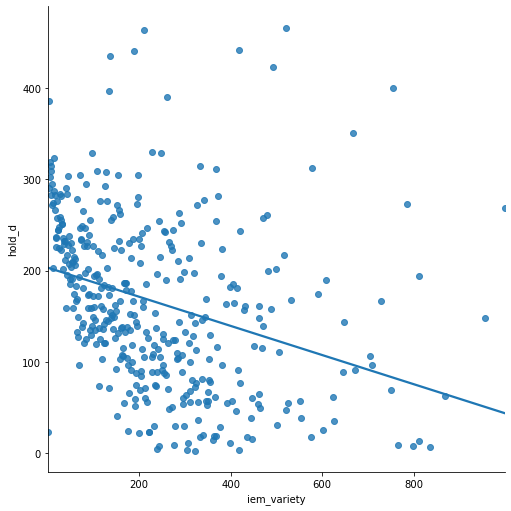

In [18]:
import seaborn as sns

# features 별 분포를 시각화하기 위해 다시 hold_d를 추가
train_data["hold_d"] = train_label
# iem_variety 분포
variety_count = train_data['hold_d'].groupby(train_data['iem_variety']).mean()
variety_count = pd.DataFrame(variety_count).reset_index()
variety_count = variety_count[variety_count['iem_variety']< 1000]
sns.lmplot(x="iem_variety", y="hold_d", 
           data= variety_count, 
           ci=None, height = 7)

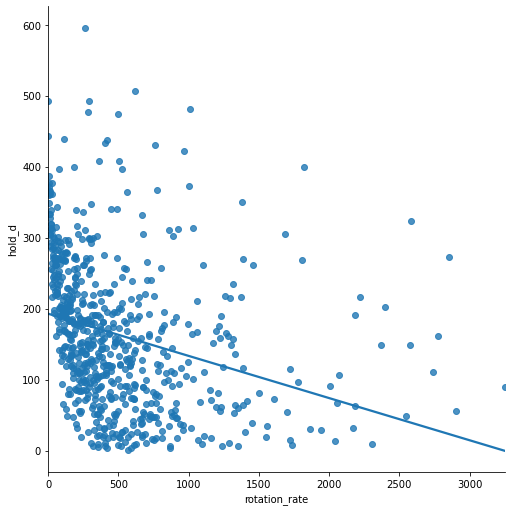

In [19]:
# rotation_rate 분포
rotation_count = train_data['hold_d'].groupby(train_data['rotation_rate']).mean()
rotation_count = pd.DataFrame(rotation_count).reset_index()
rotation_count = rotation_count[rotation_count['rotation_rate']< 3700]
sns.lmplot(x="rotation_rate", y="hold_d", 
           data= rotation_count, 
           ci=None, height = 7)

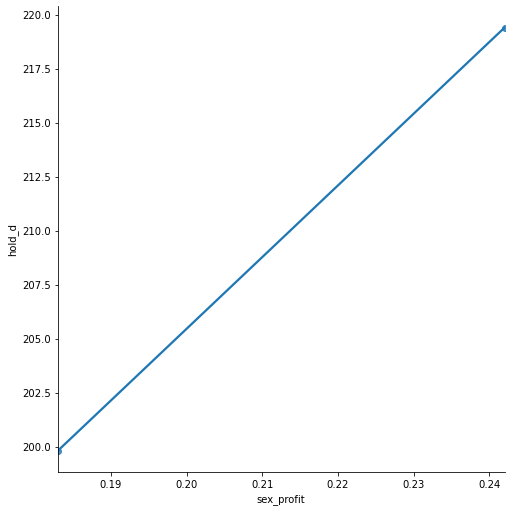

In [20]:
# sex_profit 분포
sex_count = train_data['hold_d'].groupby(train_data['sex_profit']).mean()
sex_count = pd.DataFrame(sex_count).reset_index()
sns.lmplot(x="sex_profit", y="hold_d", 
           data= sex_count, 
           ci=None, height = 7)

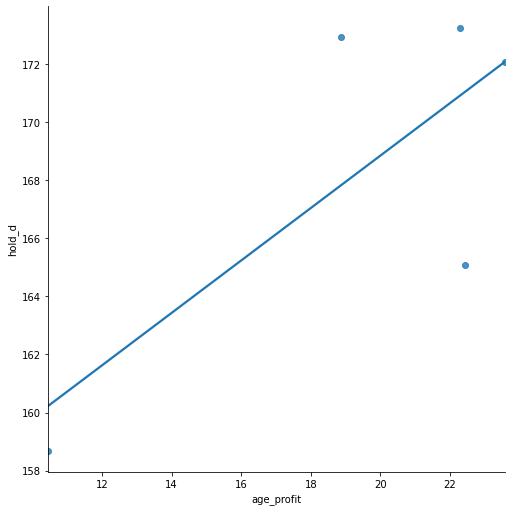

In [21]:
# age_profit 분포
age_count = train_data['hold_d'].groupby(train_data['age_profit']).std()
age_count = pd.DataFrame(age_count).reset_index()
sns.lmplot(x="age_profit", y="hold_d", 
           data= age_count, 
           ci=None, height = 7)

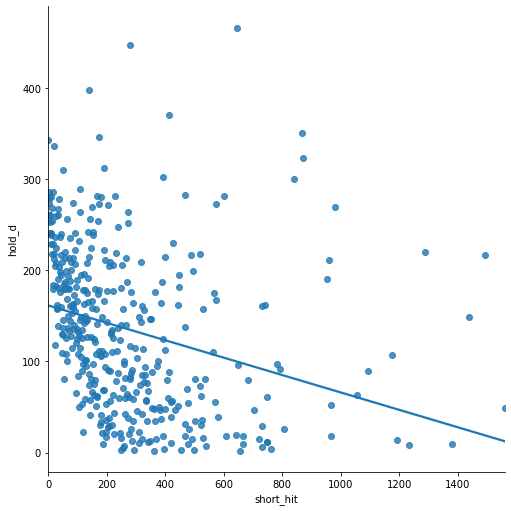

In [22]:
# short_hit 분포
short_count = train_data['hold_d'].groupby(train_data['short_hit']).mean()
short_count = pd.DataFrame(short_count).reset_index()
short_count = short_count[short_count['short_hit']< 1600]
sns.lmplot(x="short_hit", y="hold_d", 
           data= short_count, 
           ci=None, height = 7)

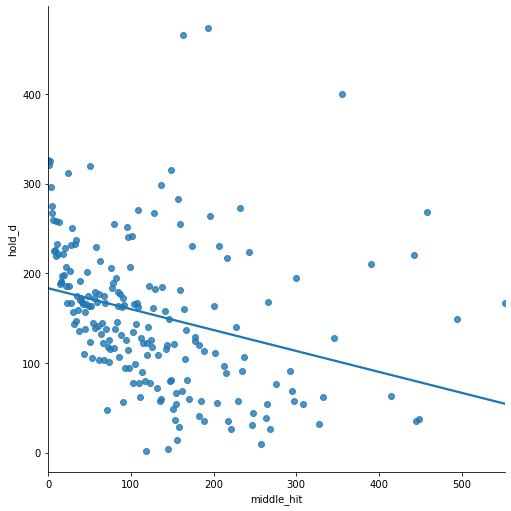

In [23]:
# middle_hit 분포
middle_count = train_data['hold_d'].groupby(train_data['middle_hit']).mean()
middle_count = pd.DataFrame(middle_count).reset_index()
middle_count = middle_count[middle_count['middle_hit']< 700]
sns.lmplot(x="middle_hit", y="hold_d", 
           data= middle_count, 
           ci=None, height = 7)

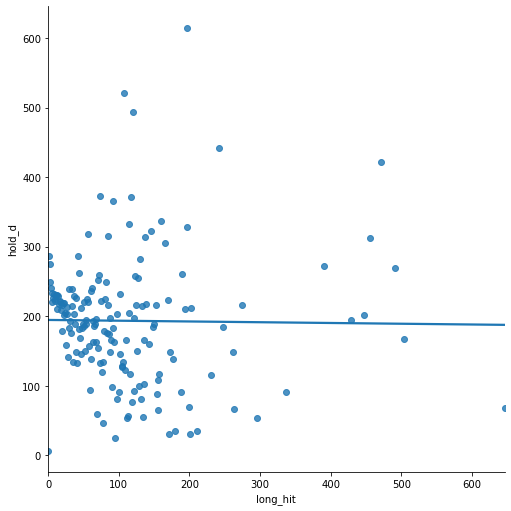

In [24]:
# long_hit 분포
long_count = train_data['hold_d'].groupby(train_data['long_hit']).mean()
long_count = pd.DataFrame(long_count).reset_index()
long_count = long_count[long_count['long_hit']< 700]
sns.lmplot(x="long_hit", y="hold_d", 
           data= long_count, 
           ci=None, height = 7)

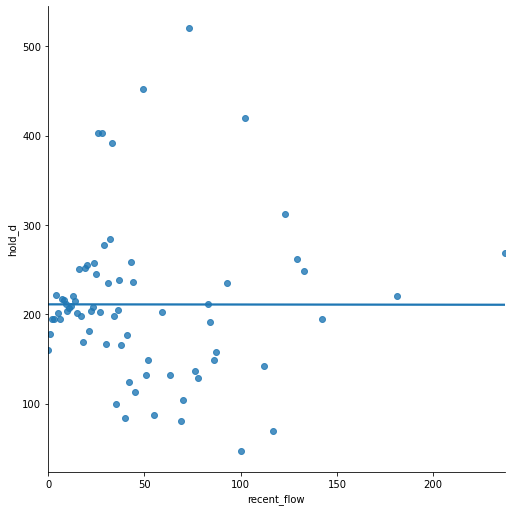

In [25]:
#recent_flow 분포
flow_count = train_data['hold_d'].groupby(train_data['recent_flow']).mean()
flow_count = pd.DataFrame(flow_count).reset_index()
#year_t_count = year_t_count[year_t_count['year_test_hold']< 1000]
sns.lmplot(x="recent_flow", y="hold_d", 
           data= flow_count, 
           ci=None, height = 7)

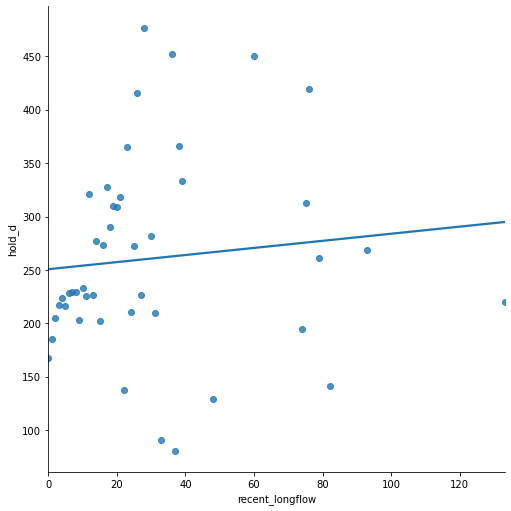

In [26]:
# recent_longflow 분포
l_flow_count = train_data['hold_d'].groupby(train_data['recent_longflow']).mean()
l_flow_count = pd.DataFrame(l_flow_count).reset_index()
l_flow_count = l_flow_count[l_flow_count['recent_longflow']< 150]
sns.lmplot(x="recent_longflow", y="hold_d", 
           data= l_flow_count, 
           ci=None, height = 7)

** 외부데이터는 2021년 데이터를 사용하지 않도록 유의합니다: Data Leakage에 해당

OS : window 10 / Jupyter notebook

In [27]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                            